Image style transfer test adapted from https://keras.io/examples/generative/neural_style_transfer/ (almost all code is copied). Includes using original VGG19 model used in original paper of Gatys et al. as well as pre-trianed ResNet50V2 (main changes were for selecting style and content layers of model and are highlighted before that section) to test if further trained models could be used for transfer as an improvement over vanilla VGG19. Results of ResNet layers were not saved, all produced a yellow layer over the image, discussed more in report. 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications import ResNet50V2

base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
#style_reference_image_path = keras.utils.get_file(
 #   "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
#)
style_reference_image_path = 'cub.jpg'
result_prefix = "generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

106496/102437 [===============================] - 0s 2us/step


In [ ]:
modelorig= vgg19.VGG19(weights="imagenet", include_top=False)
#modelorig= ResNet50V2(weights="imagenet", include_top=False)   #Line used when testing ResNet

In [ ]:
base_image_path

'me.jpg'

In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    #img = keras.applications.resnet_v2.preprocess_input(img)   #preprocessing used for ResNet test
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
#model = ResNet50V2(weights="imagenet", include_top=False)
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
#outputs_dict_orig = dict([(layer.name, layer.output) for layer in modelorig.layers])
# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

#### ResNet style layer tries in following code block

In [ ]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
   "block5_conv1",
]


#List of layers extraced as style layers from ResNet model to test its suitability for transfer

#style_layer_names = [
 #   'conv1_conv',
#    'conv2_block1_0_conv',
  #  'conv2_block1_1_conv',
 #   'conv2_block2_1_conv',
  #  'conv2_block3_1_conv',
 #   'conv3_block1_1_conv',
    #'conv3_block2_1_conv',
    #'conv3_block3_1_conv',
   # 'conv3_block4_1_conv',
   # 'conv4_block1_1_conv',
  #  'conv4_block2_1_conv',
   # 'conv4_block3_1_conv',
  #  'conv4_block4_1_conv',
   # 'conv4_block5_1_conv',
  #  'conv4_block6_1_conv'

#]#
# The layer to use for the content loss.
content_layer_name = 'block5_conv2'#[
                     # 'conv5_block1_0_conv',     #Similarly, list of content layers from ResNet used to test it
                     # 'conv5_block1_1_conv',
                     # 'conv5_block2_1_conv',
                    #  'conv5_block3_1_conv'
                       #     #                ]


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)


base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
#style_reference_image = preprocess_image('81.jpg')
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 2000 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
#keras.preprocessing.image.save_img(fname, img)

Iteration 2000: loss=506.31
Iteration 4000: loss=456.54


Iteration 1000: loss=79322.05
Iteration 2000: loss=67614.73
Iteration 3000: loss=58989.80
Iteration 4000: loss=52388.34

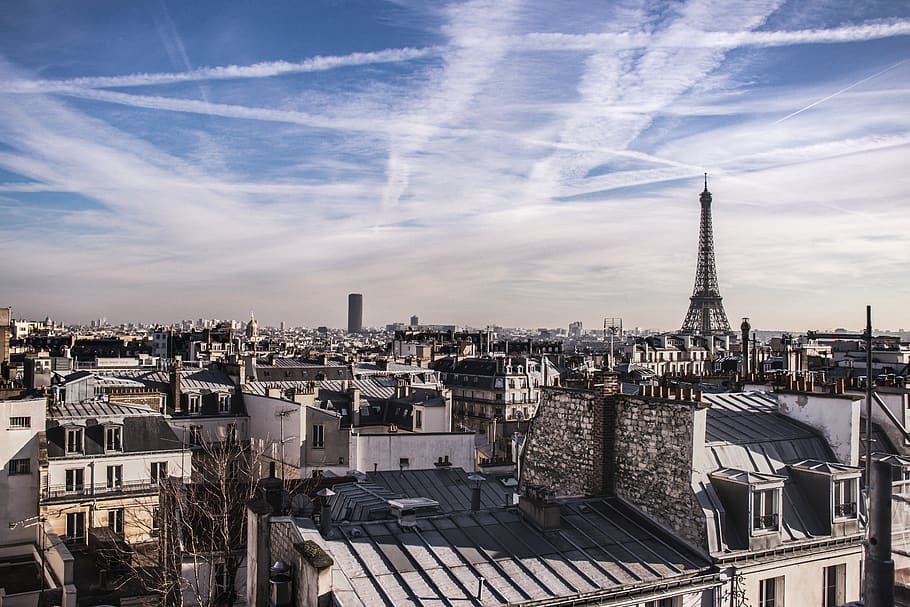

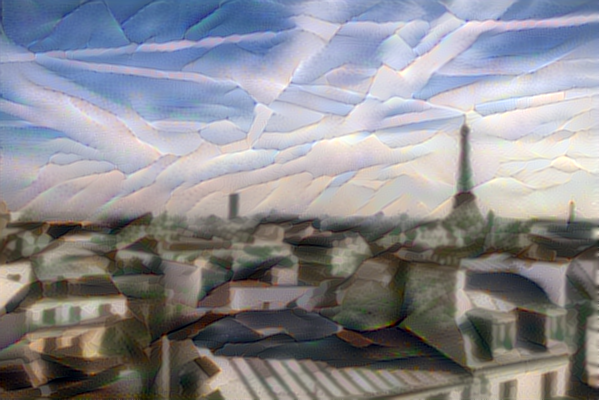

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
#display(Image(style_reference_image_path))
display(Image(result_prefix + "_at_iteration_4000.png"))

Note that above image transfer for cubism is result of original VGG19 model